# Detecting network intrusions & anomalies with higher-order topological kernels via quantum computation 

### 0. CONSTRUCTING NUMPY DATASETS

In [ ]:
import pandas as pd
import numpy as np

# Load the CSV from big dataset
filename = 'BCCC-CIC-CSE-IDS2018/Friday-02-03-2018/friday_02_03_2018_bot/friday_02_03_2018_bot.csv'

# Load the first 50 rows
df = pd.read_csv(filename, nrows=500)

# Select the top 5 anomaly-related features
selected_features = [
    'total_payload_bytes',
    'bytes_rate',
    'packets_rate',
    'avg_segment_size',
    'duration',
    'fwd_bytes_rate',
    'bwd_bytes_rate',
    'syn_flag_counts'

]

# Extract the relevant features
features_df = df[selected_features]

# # Save as CSV
# features_df.to_csv('CSV-500-botnet-benign.csv', index=False)

# Save as a NumPy array
features_array = features_df.to_numpy()
np.save('500-botnet-attack.npy', features_array)


: 

## BEGIN - TRAINING VECTORS & LOAD DATA

In [231]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
from quask.core import Ansatz, Kernel, KernelFactory, KernelType, Operation

from quask.core_implementation import QiskitKernel

In [359]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Specify the columns you want to load
# cols = ["duration", "packets_rate", "total_payload_bytes", "syn_flag_counts", "avg_segment_size", "fwd_bytes_rate", "bwd_bytes_rate", "ack_flag_counts", "fwd_avg_segment_size", "packets_count", "bytes_rate", "avg_fwd_bytes_per_bulk", "idle_mean", "fwd_packets_IAT_mean", "payload_bytes_variance"]

# cols = ["duration", "packets_rate", "total_payload_bytes", "bytes_rate", "syn_flag_counts", "avg_segment_size", "fwd_bytes_rate", "bwd_bytes_rate"]

# 11
# cols = ['src_port', 'duration', 'bytes_rate', 'packets_IAT_cov', 'packets_IAT_variance', 'fwd_packets_IAT_median', 'bwd_packets_IAT_std', 'bwd_packets_IAT_variance', 'min_bwd_packets_delta_time', 'mode_packets_delta_time', 'median_bwd_packets_delta_time']

# 10
cols = ['src_port', 'duration', 'bytes_rate', 'packets_IAT_cov', 'packets_IAT_variance', 'fwd_packets_IAT_median', 'bwd_packets_IAT_std', 'min_bwd_packets_delta_time', 'mode_packets_delta_time', 'median_bwd_packets_delta_time']

# Load only the first 200 rows and selected columns
qX1 = pd.read_csv(
    'BCCC-CIC-CSE-IDS2018/Wednesday_21_02_2018/wednesday_21_02_2018_benign_part1/wednesday_21_02_2018_benign_part1.csv',
    usecols=cols,
    nrows=2000
).to_numpy()

qX2 = pd.read_csv(
    'BCCC-CIC-CSE-IDS2018/Wednesday_21_02_2018/wednesday_21_02_2018_hoic_part1/wednesday_21_02_2018_hoic_part1.csv',
    usecols=cols,
    nrows=2000
).to_numpy()


# Transform separately
# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler.fit(np.vstack([qX1, qX2]))

# qX1 = scaler.transform(qX1)
# qX2 = scaler.transform(qX2)


In [372]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

# --- Load ---
df_attack = pd.read_csv(
    'BCCC-CIC-CSE-IDS2018/Friday-02-03-2018/friday_02_03_2018_bot/friday_02_03_2018_bot.csv',
    nrows=2000
)
df_benign = pd.read_csv(
    'BCCC-CIC-CSE-IDS2018/Friday-02-03-2018/friday_02_03_2018_benign/friday_02_03_2018_benign.csv',
    nrows=2000
)

# --- Keep numeric columns ---
X_attack = df_attack.select_dtypes(include=[np.number]).copy()
X_benign = df_benign.select_dtypes(include=[np.number]).copy()

# --- Replace inf with NaN ---
X_attack.replace([np.inf, -np.inf], np.nan, inplace=True)
X_benign.replace([np.inf, -np.inf], np.nan, inplace=True)

# # --- Drop columns with >20% missing in attack ---
# miss_thresh = 0.2
# good_cols = X_attack.isnull().mean() < miss_thresh
# X_attack = X_attack.loc[:, good_cols]
# X_benign = X_benign.loc[:, good_cols]

# # --- Drop single-value columns (attack) ---
# multi_cols = X_attack.nunique()[X_attack.nunique() > 1].index
# shared_cols = [col for col in multi_cols if col in X_benign.columns]
# X_attack = X_attack[shared_cols]
# X_benign = X_benign[shared_cols]

# # --- Drop highly collinear columns (corr > 0.95) ---
# corr = X_attack.corr().abs()
# upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
# to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
# X_attack = X_attack.drop(columns=to_drop)
# X_benign = X_benign.drop(columns=to_drop)

# --- Drop any column from benign that still has NaNs ---
no_nan_cols = X_benign.columns[~X_benign.isnull().any()]
X_attack = X_attack[no_nan_cols]
X_benign = X_benign[no_nan_cols]


qX1 = X_benign
qX2 = X_attack

# # --- Add labels and combine for GBM ---
# X_attack['label'] = 1
# X_benign['label'] = 0
# df_combined = pd.concat([X_attack, X_benign], ignore_index=True)
# y = df_combined.pop('label')
# X = df_combined


# # --- Train XGBoost GBM for feature importance ---
# model = xgb.XGBClassifier(
#     n_estimators=100,
#     use_label_encoder=False,
#     eval_metric='logloss',
#     random_state=42
# )
# model.fit(X, y)

# # --- Get feature importances ---
# importance_df = pd.DataFrame({
#     'feature': X.columns,
#     'importance': model.feature_importances_
# }).sort_values(by='importance', ascending=False)

# # --- Remove 0 importance and keep top 10 features (or fewer if not enough) ---
# importance_df = importance_df[importance_df['importance'] > 0]
# importance_df = importance_df.sort_values(by='importance', ascending=False)

# top_n = 10
# top_features = importance_df['feature'].tolist()[:top_n]

# # --- Filter final features ---
# qX1 = X_benign[top_features]
# qX2 = X_attack[top_features]

# --- Normalize to [-1, 1] ---
# scaler = MinMaxScaler(feature_range=(-1, 1))
# combined_scaled = pd.concat([qX1, qX2])
# scaler.fit(combined_scaled)

# qX1 = pd.DataFrame(scaler.transform(qX1), columns=top_features)
# qX2 = pd.DataFrame(scaler.transform(qX2), columns=top_features)

# --- Final Output ---
print("Final selected features:", qX2.columns)
print("Benign shape:", qX1.shape)
print("Attack shape:", qX2.shape)


Final selected features: Index(['src_port', 'dst_port', 'duration', 'packets_count',
       'fwd_packets_count', 'bwd_packets_count', 'total_payload_bytes',
       'fwd_total_payload_bytes', 'bwd_total_payload_bytes',
       'payload_bytes_max',
       ...
       'median_bwd_payload_bytes_delta_len',
       'skewness_bwd_payload_bytes_delta_len',
       'min_fwd_payload_bytes_delta_len', 'max_fwd_payload_bytes_delta_len',
       'mean_fwd_payload_bytes_delta_len', 'mode_fwd_payload_bytes_delta_len',
       'variance_fwd_payload_bytes_delta_len',
       'std_fwd_payload_bytes_delta_len', 'median_fwd_payload_bytes_delta_len',
       'skewness_fwd_payload_bytes_delta_len'],
      dtype='object', length=298)
Benign shape: (2000, 298)
Attack shape: (2000, 298)


In [280]:
# qX1 = np.load('hoic2benign_200.npy', allow_pickle=True)
# qX2 = np.load('hoic2attack_200.npy', allow_pickle=True)

In [281]:
# columns = [3, 4, 5, 6, 7, 8, 9, 10]
# qX1 = qX1[:200,columns]
# qX2 = qX2[:200,columns]

In [374]:
qX = np.row_stack([qX1, qX2])
qy = np.array([-1] * len(qX1) + [1] * len(qX2))

print(f"{qX.shape=}")
print(f"{qy.shape=}")

qX.shape=(4000, 298)
qy.shape=(4000,)


In [375]:
qX_train, qX_test, qy_train, qy_test = train_test_split(qX, qy, test_size=0.2, random_state=42)

print("Shape training set:", qX_train.shape, qy_train.shape)
print("Shape testing set:", qX_test.shape, qy_test.shape)
print("Example of feature:", qX_train[0])
print("Example of label:", qy_train[0])

Shape training set: (3200, 298) (3200,)
Shape testing set: (800, 298) (800,)
Example of feature: [ 5.30190000e+04  8.08000000e+03  1.51090622e-02  9.00000000e+00
  5.00000000e+00  4.00000000e+00  4.55000000e+02  3.26000000e+02
  1.29000000e+02  3.26000000e+02  0.00000000e+00  5.05556000e+01
  1.03336700e+02  1.06784691e+04  0.00000000e+00  2.04570000e+00
  0.00000000e+00  3.26000000e+02  0.00000000e+00  5.05556000e+01
  1.03336700e+02  1.70041600e+04  0.00000000e+00  1.50000000e+00
  0.00000000e+00  3.26000000e+02  0.00000000e+00  5.05556000e+01
  1.03336700e+02  2.16818750e+03  8.50000000e+00  1.08110000e+00
  0.00000000e+00  2.04000000e+02  3.20000000e+01  2.00000000e+01
  2.26667000e+01  4.98890000e+00  2.00000000e+01  1.33630000e+00
  2.20100000e-01  2.00000000e+01  2.48889000e+01  1.12000000e+02
  3.20000000e+01  2.00000000e+01  2.24000000e+01  4.80000000e+00
  2.00000000e+01  1.50000000e+00  2.14300000e-01  2.00000000e+01
  2.30400000e+01  9.20000000e+01  3.20000000e+01  2.000000

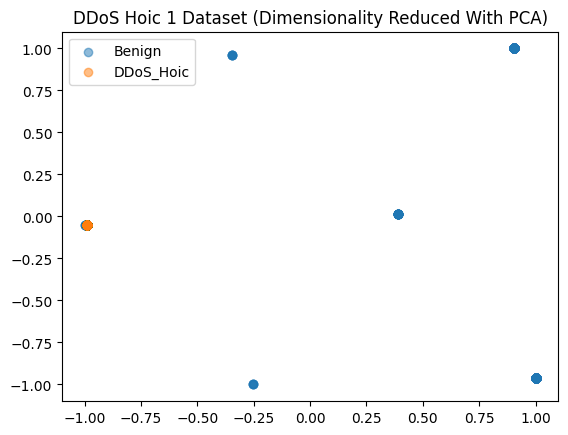

In [376]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


class_labels = [r'Benign', r'DDoS_Hoic']
pca = PCA(n_components=2).fit(qX_train)
X_train = pca.transform(qX_train)
X_test = pca.transform(qX_test)

samples = np.append(X_train, X_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
X_train = minmax_scale.transform(X_train)
X_test = minmax_scale.transform(X_test)

training_input = {key: (X_train[qy_train == k, :])[:3200] for k, key in enumerate(class_labels)}
test_input = {key: (X_test[qy_test == k, :])[:800] for k, key in enumerate(class_labels)}


label_mapping = { -1: 'Benign', 1: 'DDoS_Hoic' }


for k in [-1, 1]:
    x_axis_data = X_train[qy_train == k, 0][:3200]
    y_axis_data = X_train[qy_train == k, 1][:3200]
    plt.scatter(x_axis_data, y_axis_data, label=label_mapping[k], alpha=0.5)

plt.title("DDoS Hoic 1 Dataset (Dimensionality Reduced With PCA)")
plt.legend()
plt.show()

/tmp/ipykernel_12981/2285627515.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


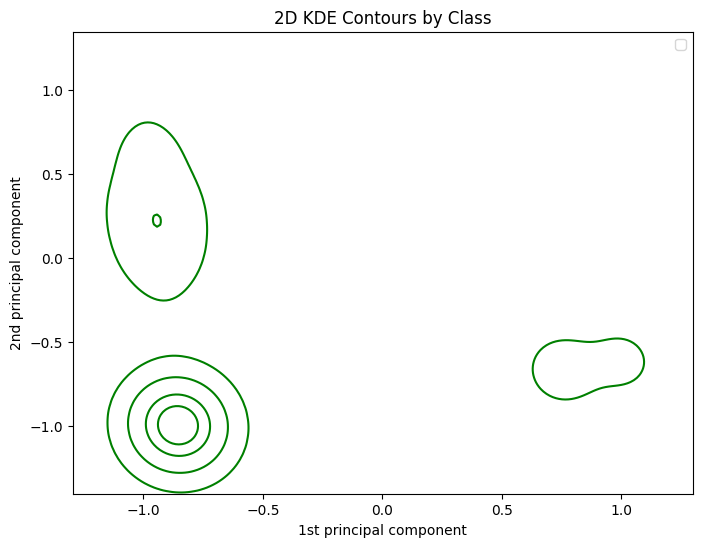

In [367]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for k, color in zip([-1, 1], ['green','red']):
    mask = (qy_train == k)
    sns.kdeplot(
        x=X_train[mask,0],
        y=X_train[mask,1],
        levels=5,
        thresh=0.05,
        fill=False,
        color=color,
        label=label_mapping[k]
    )

plt.title("2D KDE Contours by Class")
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.legend()
plt.show()


In [328]:
import numpy as np

# how many total points?
print("Total train points:", X_train.shape[0])

# how many unique 2-D points?
uniq = np.unique(np.round(X_train, 6), axis=0)
print("Unique (x,y) coords after PCA+scaling:", uniq.shape[0])


Total train points: 320
Unique (x,y) coords after PCA+scaling: 5


In [311]:
print("Benign samples in training:", np.sum(qy_train == -1))
print("Bot samples in training:", np.sum(qy_train == 1))


Benign samples in training: 156
Bot samples in training: 164


In [284]:
# Instantiate a machine learning model
model = SVC(kernel='precomputed')

## BUILD QUANTUM KERNEL

In [285]:
from quask.core_implementation.qiskit_kernel import QiskitKernel
from quask.core import KernelType
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler

# SIMULATED AER BACKEND
def create_qiskit_noiseless(ansatz, measurement: str, type: KernelType):
    # Here platform="infty_shots" forces Estimator/Aer path inside QiskitKernel
    return QiskitKernel(
        ansatz,
        measurement,
        type,
        platform="infty_shots",
        n_shots=None  # None means no sampling, use statevector/estimator
    )

# REAL QUANTUM BACKEND
# _service = QiskitRuntimeService()  # ensure credentials/configured
# backend = _service.backend("ibm_rensselaer", instance="rpi-rensselaer/classes/itws-4940-callab")
# options = {
#     "dynamical_decoupling": {"sequence_type": "XX", "enable": False},
#     "twirling": {"enable_gates": False, "enable_measure": False, "num_randomizations": "auto", "shots_per_randomization": "auto"}
# }

# # Example factory for a real IBM backend with given options
# def create_qiskit_ibm(ansatz, measurement: str, type: KernelType):
#     return QiskitKernel(
#         ansatz,
#         measurement,
#         type,
#         platform="ibm_quantum",    # or leave default so QiskitKernel picks job mode
#         n_shots=2048,
#         options=options,
#         backend=backend,
#     )

Add to Factory

In [286]:
from quask.core import KernelFactory, Ansatz

# Register the noiseless factory
# KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
# Register the IBM backend factory
# KernelFactory.add_implementation('qiskit_ibm', create_qiskit_ibm)

# Choose which one is the default for create_kernel calls:
KernelFactory.set_current_implementation('qiskit_noiseless')
# ...later, if you want to switch:
# KernelFactory.set_current_implementation('qiskit_ibm')

In [287]:
# print(qX_train)
# print(qy_train)

Define ansatz ops

In [288]:
# # Define some information about the parameterized quantum circuit
# N_FEATURES = 3
# N_QUBITS = 3

# # Create a random operation
# allowed_generators = Operation.PAULI_GENERATORS
# generators = np.random.choice(allowed_generators)

# allowed_qubits = list(range(N_QUBITS))
# wires = np.random.choice(allowed_qubits, 2, replace=False)

# allowed_features_plus_constant_element = list(range(N_FEATURES + 1))
# feature = np.random.choice(allowed_features_plus_constant_element)

# bandwidth = np.random.uniform(0.0, 1.0)

# operation = Operation(generators, wires, feature, bandwidth)
# print(operation)

In [289]:
# N_FEATURES = 3
# N_OPERATIONS = 3
# N_QUBITS = 3
# ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
# ansatz.initialize_to_identity()

# # parameterized rotation R_{ZZ}(x_0) on the qubits 0, 1
# ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="ZZ", new_bandwidth=1.0)

# # parameterized rotation R_{XX}(x_1) on the qubits 0, 1
# ansatz.change_operation(1, new_feature=1, new_wires=[0, 1], new_generator="XX", new_bandwidth=1.0)

# # constant R_x(0.123) of the qubit 1 (the second)
# ansatz.change_operation(2, new_feature=2, new_wires=[0, 1], new_generator="IX", new_bandwidth=0.123)

In [290]:
# ansatz = Ansatz(n_features=1, n_qubits=1, n_operations=1)
# ansatz.initialize_to_identity()
# # e.g. set operations...
# ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.1)
# ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.1)
# ansatz.change_operation(2, new_feature=2, new_wires=[2, 1], new_generator="XZ", new_bandwidth=0.1)

In [ ]:
ansatz = Ansatz(n_features=6, n_qubits=4, n_operations=6)
ansatz.initialize_to_identity()
# e.g. set operations...
ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.2)
ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.2)
ansatz.change_operation(2, new_feature=2, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.2)
ansatz.change_operation(3, new_feature=3, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.2)
ansatz.change_operation(4, new_feature=4, new_wires=[0, 1], new_generator="YY", new_bandwidth=0.2)
ansatz.change_operation(5, new_feature=5, new_wires=[1, 2], new_generator="YZ", new_bandwidth=0.2)
ansatz.change_operation(6, new_feature=6, new_wires=[2, 3], new_generator="ZX", new_bandwidth=0.2)
ansatz.change_operation(7, new_feature=7, new_wires=[3, 0], new_generator="ZY", new_bandwidth=0.2)

ansatz.change_operation(8, new_feature=8, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.2)
ansatz.change_operation(9, new_feature=9, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.2)
ansatz.change_operation(10, new_feature=10, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.2)
ansatz.change_operation(11, new_feature=11, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.2)
ansatz.change_operation(12, new_feature=12, new_wires=[0, 1], new_generator="YY", new_bandwidth=0.2)
ansatz.change_operation(13, new_feature=13, new_wires=[1, 2], new_generator="ZX", new_bandwidth=0.2)
ansatz.change_operation(14, new_feature=14, new_wires=[2, 3], new_generator="ZY", new_bandwidth=0.2)

ansatz.change_operation(12, new_feature=12, new_wires=[0, 1], new_generator="YY", new_bandwidth=0.2)
ansatz.change_operation(13, new_feature=13, new_wires=[1, 2], new_generator="ZX", new_bandwidth=0.2)
ansatz.change_operation(14, new_feature=14, new_wires=[2, 3], new_generator="ZY", new_bandwidth=0.2)


Create KernelFactory

In [292]:
# kernel = KernelFactory.create_kernel(ansatz, "ZZZ", KernelType.FIDELITY)

In [293]:
kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)

# kernel.service = _service # This will invoke whichever implementation is current (e.g., create_qiskit_noiseless).

Set up a Session

In [294]:
# batch all jobs in a session
# with Session(backend=backend) as session:
#     kernel._session = session
#     kernel._sampler = Sampler(session=session)

#     K_train = kernel.build_kernel(X_train, X_train, matrix="train")


K_train = kernel.build_kernel(qX_train, qX_train, matrix="train") # train data
print(K_train)

[[ 1.          0.70832556  0.74070121 ... -0.83148738  0.52890596
   0.1707517 ]
 [ 0.70832556  1.          0.05099426 ... -0.98102092  0.97369046
  -0.30581584]
 [ 0.74070121  0.05099426  1.         ... -0.2435436  -0.17780933
   0.52207531]
 ...
 [-0.83148738 -0.98102092 -0.2435436  ...  1.         -0.91113039
   0.19294831]
 [ 0.52890596  0.97369046 -0.17780933 ... -0.91113039  1.
  -0.41761812]
 [ 0.1707517  -0.30581584  0.52207531 ...  0.19294831 -0.41761812
   1.        ]]


Fit trained data to model

In [295]:
model.fit(K_train, qy_train)

SVC(kernel='precomputed')

In [296]:
# Predict the labels for the test data
K_test = kernel.build_kernel(qX_test, qX_train, matrix="test")
y_pred = model.predict(K_test)

In [297]:
# Calculate the accuracy
accuracy = np.sum(qy_test == y_pred) / len(qy_test)
print("Accuracy:", accuracy)

Accuracy: 0.5625


## Visualizations

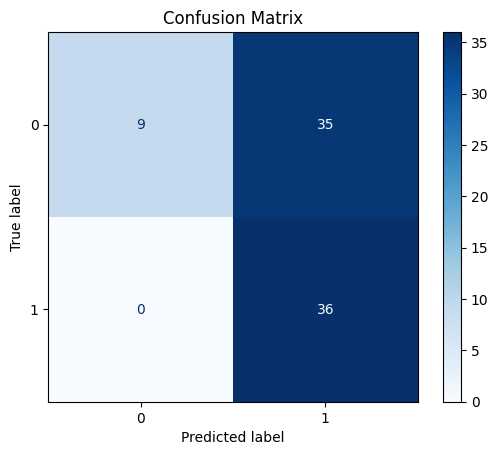

In [298]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

cm = confusion_matrix(qy_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()